In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize # for optimization
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster # for hierarchical clustering
from scipy.spatial.distance import squareform # to convert distance matrix to condensed form
from sklearn.metrics import silhouette_score # for calculating silhouette scores
from kneed import KneeLocator # for finding the knee point in the silhouette score curve
from itertools import combinations # for generating combinations of stocks
import edhec_risk_kit as erk # for financial risk metrics

In [94]:
import yfinance as yf # for fetching stock data

In [95]:
symbols = [
    "AKBNK.IS", "ARCLK.IS", "ASELS.IS", "BIMAS.IS", "EKGYO.IS",
    "EUPWR.IS", "FROTO.IS", "GARAN.IS", "GUBRF.IS",
    "ISCTR.IS", "KCHOL.IS", "KOZAA.IS", "KOZAL.IS", "PGSUS.IS",
    "SAHOL.IS", "SASA.IS", "SISE.IS", "TCELL.IS", "THYAO.IS",
    "TKFEN.IS", "TOASO.IS", "TUPRS.IS", "VAKBN.IS",
    "YKBNK.IS", "ALARK.IS", "SOKM.IS", "ODAS.IS"
]
# Creating a dataframe named symbols, with Yahoo Finance tickers for BIST equities

In [96]:
data = yf.download(symbols, start="2010-01-01", end="2025-07-02", auto_adjust=False)['Adj Close'] # Downloading adjusted close prices for the specified symbols from Yahoo Finance

[*********************100%***********************]  27 of 27 completed


In [97]:
min_valid_ratio = 0.999 # Minimum valid ratio for data cleaning, to keep columns with at least 99.9% valid data
# This means we will drop columns with more than 0.1% missing values
data_clean = data.loc[:, data.isnull().mean() < (1 - min_valid_ratio)] # Drop columns with more than 0.1% missing values
data_clean.head()
data_clean.columns

Index(['AKBNK.IS', 'ALARK.IS', 'ARCLK.IS', 'ASELS.IS', 'BIMAS.IS', 'FROTO.IS',
       'GARAN.IS', 'GUBRF.IS', 'ISCTR.IS', 'KCHOL.IS', 'KOZAA.IS', 'SAHOL.IS',
       'SASA.IS', 'SISE.IS', 'TCELL.IS', 'THYAO.IS', 'TKFEN.IS', 'TOASO.IS',
       'TUPRS.IS', 'VAKBN.IS', 'YKBNK.IS'],
      dtype='object', name='Ticker')

<Axes: xlabel='Date'>

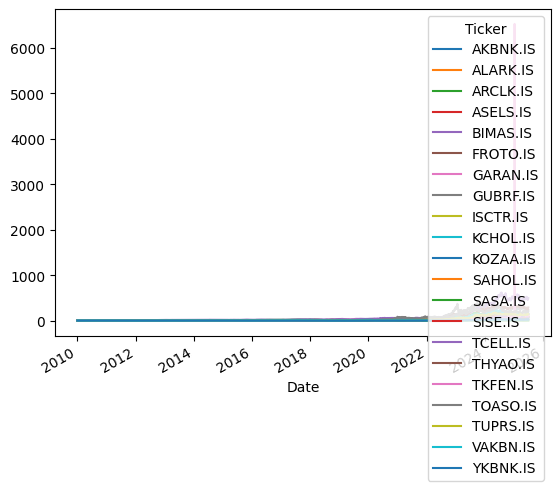

In [98]:
data_clean.plot()

In [99]:
data_clean["TKFEN.IS"]["2025-01-01":"2025-01-31"]

Date
2025-01-02      64.849998
2025-01-03      64.500000
2025-01-06      65.300003
2025-01-07      67.550003
2025-01-08      65.400002
2025-01-09      65.199997
2025-01-10    6520.000000
2025-01-13      62.150002
2025-01-14      64.599998
2025-01-15      66.099998
2025-01-16      66.250000
2025-01-17      65.050003
2025-01-20      64.199997
2025-01-21      63.549999
2025-01-22      63.849998
2025-01-23      64.449997
2025-01-24      63.750000
2025-01-27      63.549999
2025-01-28      64.000000
2025-01-29      63.000000
2025-01-30      64.199997
2025-01-31      63.750000
Name: TKFEN.IS, dtype: float64

In [100]:
data_clean["TKFEN.IS"]["2025-01-10"] = data_clean["TKFEN.IS"]["2025-01-10"]/100
#Due to an error in the incoming data, the price was being calculated as 6520. We corrected this by dividing the price by 100. We can also use the mean or median of the previous and next days to correct this error.

C:\Users\Sercan\AppData\Local\Temp\ipykernel_6732\1943214925.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_clean["TKFEN.IS"]["2025-01-10"] = data_clean["TKFEN.IS"]["2025-01-10"]/100
C:\Users\Sercan\AppData\Local\Temp\ipykernel_673

<Axes: xlabel='Date'>

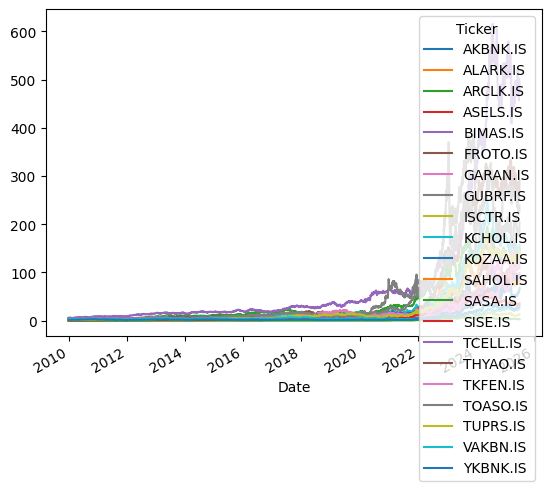

In [101]:
data_clean.plot()

Global Return Calculation

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

In [102]:
returns = data_clean.pct_change().dropna() # Calculating daily returns
mean_returns = returns.mean() # Calculating mean returns
cov_matrix = returns.cov() # Calculating covariance matrix of returns
corr_matrix = returns.corr() # Calculating the correlation matrix of daily returns
distance_matrix = np.sqrt(2 * (1 - corr_matrix)) # Calculating the distance matrix using the correlation matrix
distance_vector = squareform(distance_matrix.values, checks=False) # Converting the distance matrix to a condensed distance vector
periods_per_year = 252
annual_rf = 0.4707 # Annual risk-free rate for Turkey, as of 2025-07-02

C:\Users\Sercan\AppData\Local\Temp\ipykernel_6732\117451854.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data_clean.pct_change().dropna() # Calculating daily returns


In [103]:
returns.head()

Ticker,AKBNK.IS,ALARK.IS,ARCLK.IS,ASELS.IS,BIMAS.IS,FROTO.IS,GARAN.IS,GUBRF.IS,ISCTR.IS,KCHOL.IS,...,SAHOL.IS,SASA.IS,SISE.IS,TCELL.IS,THYAO.IS,TKFEN.IS,TOASO.IS,TUPRS.IS,VAKBN.IS,YKBNK.IS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.010417,0.005025,0.000000,0.169644,0.000000,0.022222,-0.007874,0.006250,0.0,0.004525,...,0.008772,0.034020,0.037635,0.009434,0.017699,-0.008097,-0.004237,0.016807,0.009434,-0.018181
2010-01-05,0.010526,0.025000,0.025424,0.007632,0.007299,0.021739,0.023809,0.049689,0.0,0.067568,...,0.008696,0.000000,0.000000,0.037383,0.000000,0.061224,0.042553,0.041323,0.032710,0.037037
2010-01-06,-0.005208,0.058537,0.033058,-0.022727,0.000000,0.005319,0.000000,0.029586,0.0,0.004219,...,-0.017242,-0.016450,0.005181,0.027027,-0.008696,0.028846,-0.004082,0.000000,-0.009050,0.017857
2010-01-07,0.000000,0.009217,-0.008000,0.062016,0.000000,0.010582,0.015504,0.017242,0.0,-0.004202,...,0.000000,0.033130,0.000000,0.026316,-0.017544,0.000000,0.036885,0.000000,-0.004566,0.011696
2010-01-08,0.000000,0.000000,-0.016129,0.000000,0.000000,0.026178,0.007634,-0.022599,0.0,0.000000,...,0.026316,0.048568,0.005154,-0.017094,-0.017857,0.018691,0.017787,-0.007937,0.004587,0.005780


<Axes: xlabel='Date'>

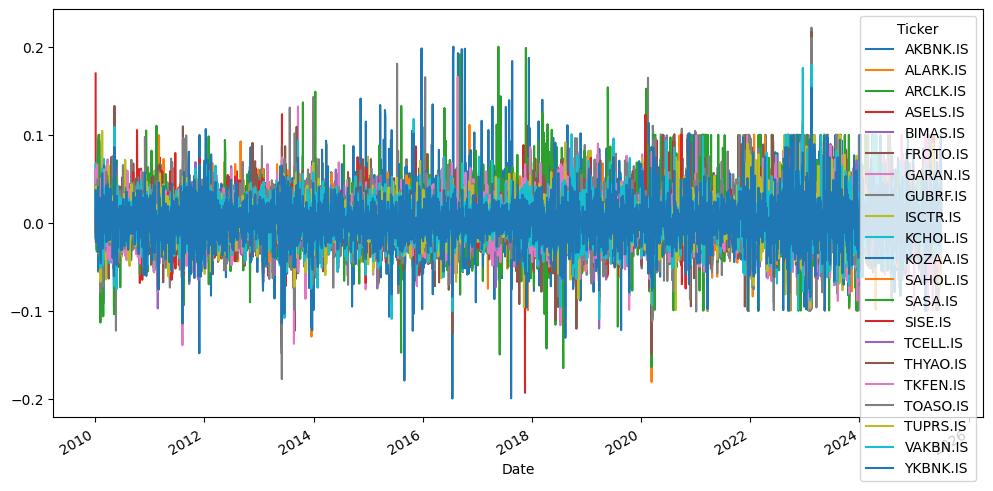

In [104]:
returns.plot(figsize=(12,6))

# Clustering

In [105]:
dend = linkage(distance_vector, method='ward') # Performing hierarchical clustering using Ward's method
# Ward's method minimizes the variance of clusters being merged.

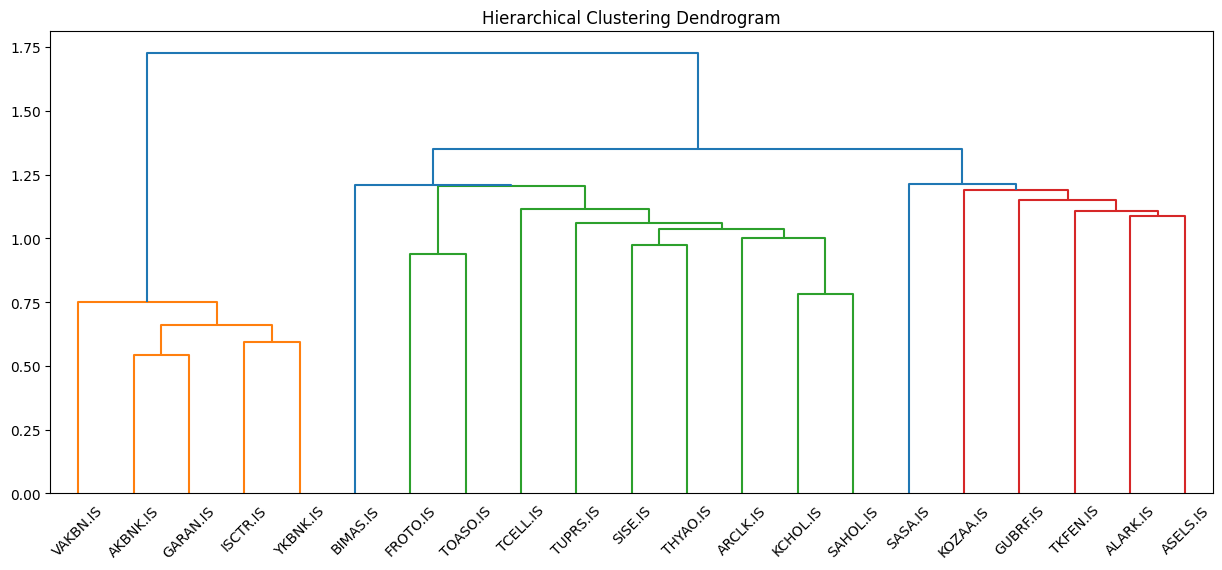

In [106]:
plt.figure(figsize=(15, 6))
dendrogram(dend, labels=distance_matrix.index)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [107]:
scores = []
for n_clusters in range(2, 11):  # min 2, max 10 cluster dener
    labels = fcluster(dend, n_clusters, criterion='maxclust') # Assigning cluster labels based on the hierarchical clustering
    # fcluster creates flat clusters from the hierarchical clustering defined by the linkage matrix.
    score = silhouette_score(distance_matrix, labels, metric='precomputed') # Calculating the silhouette score for the clustering
    # The silhouette score measures how similar an object is to its own cluster compared to other clusters
    scores.append(score)
    print(f"Cluster: {n_clusters}, Silhouette Score: {score:.4f}")

Cluster: 2, Silhouette Score: 0.0629
Cluster: 3, Silhouette Score: 0.0702
Cluster: 4, Silhouette Score: 0.0731
Cluster: 5, Silhouette Score: 0.0757
Cluster: 6, Silhouette Score: 0.0805
Cluster: 7, Silhouette Score: 0.0825
Cluster: 8, Silhouette Score: 0.0844
Cluster: 9, Silhouette Score: 0.0848
Cluster: 10, Silhouette Score: 0.0866


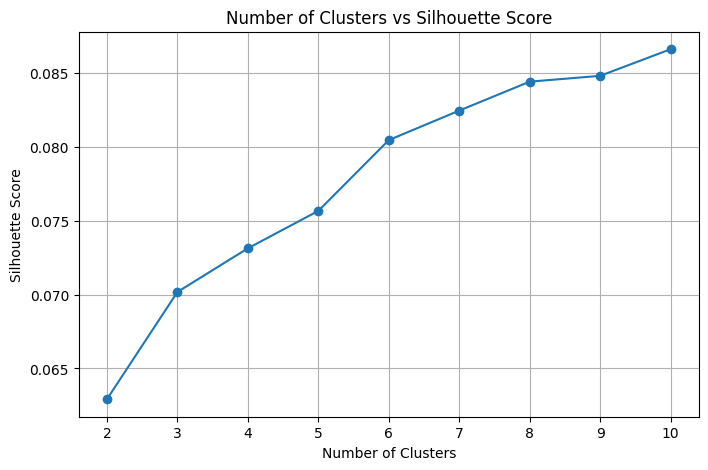

In [108]:
cluster_range = list(range(2, len(scores) + 2)) # Creating a range for the number of clusters
# This will be used for plotting the silhouette scores against the number of clusters
plt.figure(figsize=(8,5))
plt.plot(cluster_range, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Number of Clusters vs Silhouette Score')
plt.grid(True)
plt.show()

In [109]:
kneedle = KneeLocator(cluster_range, scores, S=1.0, curve="concave", direction="increasing")
optimal_clusters = int(kneedle.elbow)
print("Knee/elbow detected at:", optimal_clusters)

# KneeLocator automatically detects the "elbow point" in the silhouette score curve,
# which corresponds to the most meaningful and interpretable number of clusters in the data,
# as recommended by Hastie, Tibshirani, and Friedman (2009) and Tsay (2010).
# The elbow method ensures that we avoid excessive fragmentation and select a parsimonious clustering solution.

Knee/elbow detected at: 6


In [110]:
labels = fcluster(dend, optimal_clusters, criterion='maxclust')
clusters_df = pd.DataFrame({
    'Stock': distance_matrix.index,
    'Cluster': labels
})
print(clusters_df.sort_values('Cluster'))
# The clusters_df DataFrame shows the stocks and their assigned cluster labels.

       Stock  Cluster
0   AKBNK.IS        1
6   GARAN.IS        1
8   ISCTR.IS        1
19  VAKBN.IS        1
20  YKBNK.IS        1
17  TOASO.IS        2
5   FROTO.IS        2
13   SISE.IS        3
15  THYAO.IS        3
14  TCELL.IS        3
9   KCHOL.IS        3
2   ARCLK.IS        3
18  TUPRS.IS        3
11  SAHOL.IS        3
4   BIMAS.IS        4
1   ALARK.IS        5
16  TKFEN.IS        5
10  KOZAA.IS        5
3   ASELS.IS        5
7   GUBRF.IS        5
12   SASA.IS        6


# Markowitz

In [111]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes the returns of a Series or DataFrame
    """
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods) - 1
# This function calculates the annualized return based on the compounded growth of returns.

In [112]:
def annualize_vol(r, periods_per_year):
    """
    Annualizes the volatility of a Series or DataFrame
    """
    return r.std()* (periods_per_year**0.5)
# This function calculates the annualized volatility based on the standard deviation of returns.

In [113]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the Sharpe Ratio of a Series or DataFrame
    """
    rf_per_period = (1 + riskfree_rate)**(1/periods_per_year) - 1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret / ann_vol
# This function calculates the Sharpe Ratio, which is a measure of risk-adjusted return.

In [114]:
def portfolio_return(weights, returns):
    """
    Compute the return of a portfolio given weights and returns.
    """
    weights = np.array(weights)  # Ensure weights is a numpy array
    return weights.T @ returns
# This function calculates the portfolio return based on the weights and returns of the assets.

In [115]:
def portfolio_vol(weights, covmat):
    """
    Compute the variance of a portfolio given weights and the covariance matrix.
    """
    weights = np.array(weights)  # Ensure weights is a numpy array
    return (weights.T @ covmat @ weights)**0.5
# This function calculates the portfolio volatility based on the weights and covariance matrix of returns.

In [116]:
def minimize_vol(target_return, er, cov):
    """
    Minimize the portfolio volatility for a given target return.
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0), )*n
    return_is_target = {
        'type': 'eq',
        'args':(er, ),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(portfolio_vol,init_guess,
                       args=(cov, ), method='SLSQP',
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds)
    return results.x
# This function minimizes the portfolio volatility for a given target return using the Sequential Least Squares Programming (SLSQP) method.

In [117]:
def optimal_weights(n_points, er, cov):
    """
    Generate optimal portfolio weights for a given number of points.
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
# This function generates optimal portfolio weights for a range of target returns, which will be used to plot the efficient frontier.

In [118]:
def msr(riskfree_rate, er, cov):
    """
    Minimize the portfolio volatility for a given riskfree_rate.
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0), )*n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Compute the negative Sharpe ratio for a given set of weights.
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    results = minimize(neg_sharpe_ratio, init_guess,
                   args=(riskfree_rate, er, cov), method='SLSQP',
                   options={'disp': False},
                   constraints=(weights_sum_to_1),
                   bounds=bounds)
    return results.x
# This function calculates the weights of the portfolio that maximizes the Sharpe Ratio for a given risk-free rate, expected returns, and covariance matrix.

In [119]:
def gmv(cov):
    """
    Compute the Global Minimum Variance portfolio weights.
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1/n, n), cov)
# This function calculates the weights of the Global Minimum Variance portfolio, which minimizes the portfolio variance for a given covariance matrix.

In [120]:
def plot_ef(n_points, er, cov, style = ".-", show_cml=False, riskfree_rate=0.0, show_ew = False, show_gmv = False):
    """
    Plots the efficient frontier for a given number of points.
    """
    # Generate random portfolio weights
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Returns': rets, 'Volatility': vols})
    ax = ef.plot.line(x='Volatility', y='Returns', style=style)
    if show_ew: # Plotting the equal-weighted portfolio
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot(vol_ew, r_ew, color='goldenrod', marker = "o", markersize = 12)
    if show_gmv: # Plotting the Global Minimum Variance portfolio
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot(vol_gmv, r_gmv, color='midnightblue', marker = "o", markersize = 10)

    if show_cml: # Plotting the Capital Market Line (CML)
        ax.set_xlim(left=0)
        w_msr = msr(riskfree_rate, er ,cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        cml_x =[0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker = "o", linestyle = "dashed", markersize=12, linewidth=2, label='CML')
    return ax

## Selected Max Return Portfolio

In [121]:
selected_stocks = []
for cl in clusters_df['Cluster'].unique():
    stocks_in_cluster = clusters_df[clusters_df['Cluster'] == cl]['Stock']
    ann_returns = returns[stocks_in_cluster].apply(lambda r: annualize_rets(r, periods_per_year))
    best_stock = ann_returns.idxmax() # Maximizing the annualized return to select the representative stock for each cluster
    selected_stocks.append(best_stock)
print(selected_stocks)
# The selected_stocks list contains the representative stocks for each cluster based on the highest annualized return.
# These stocks can be used for further analysis or portfolio construction.

['GARAN.IS', 'ASELS.IS', 'TUPRS.IS', 'BIMAS.IS', 'FROTO.IS', 'SASA.IS']


In [122]:
er = annualize_rets(returns[selected_stocks], periods_per_year=periods_per_year) # Annualized returns for the selected stocks
cov = returns[selected_stocks].cov() * periods_per_year # Covariance matrix of the selected stocks' returns, annualized
er

Ticker
GARAN.IS    0.244324
ASELS.IS    0.486420
TUPRS.IS    0.334223
BIMAS.IS    0.326133
FROTO.IS    0.369063
SASA.IS     0.561816
dtype: float64

In [123]:
annualize_vol(returns[selected_stocks], periods_per_year=annual_rf) # Annualized volatility of the selected stocks


Ticker
GARAN.IS    0.016736
ASELS.IS    0.016314
TUPRS.IS    0.014704
BIMAS.IS    0.013082
FROTO.IS    0.016110
SASA.IS     0.020822
dtype: float64

In [124]:
sharpe_ratio(returns[selected_stocks], riskfree_rate=annual_rf, periods_per_year=periods_per_year) # Sharpe Ratio of the selected stocks, which measures the risk-adjusted return of the portfolio

Ticker
GARAN.IS   -0.398295
ASELS.IS    0.028070
TUPRS.IS   -0.273387
BIMAS.IS   -0.325439
FROTO.IS   -0.185934
SASA.IS     0.128410
dtype: float64

<Axes: xlabel='Volatility'>

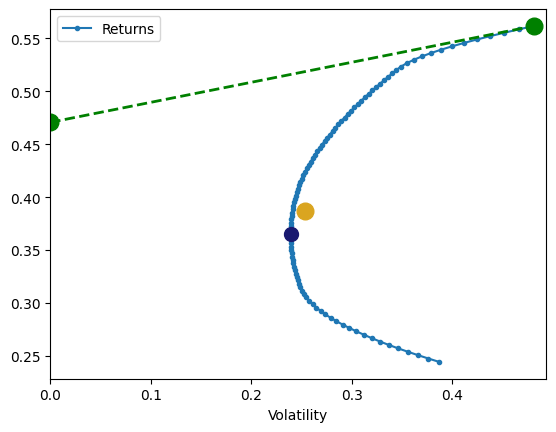

In [125]:
plot_ef(n_points=100, er=er, cov=cov,
           riskfree_rate=annual_rf, show_ew=True, show_gmv=True, show_cml=True) # Plotting the Efficient Frontier (EF) with the selected stocks
# The plot shows the efficient frontier, the equal-weighted portfolio, the global minimum variance portfolio

In [126]:
weights_gmv = gmv(cov) # Calculating the Global Minimum Variance (GMV) portfolio weights
weights_msr = msr(riskfree_rate=annual_rf, er=er, cov=cov) # Calculating the Maximum Sharpe Ratio (MSR) portfolio weights
print("\n=== WEIGHTS GMV PORTFOY ===")


=== WEIGHTS GMV PORTFOY ===


In [127]:
portfolio_return(weights_gmv, er) # Expected return of the GMV portfolio
portfolio_vol(weights_gmv, cov) # Expected volatility of the GMV portfolio
portfolio_return(weights_msr, er) # Expected return of the MSR portfolio
portfolio_vol(weights_msr, cov) # Expected volatility of the MSR portfolio
print("GMV Portfolio Return:", portfolio_return(weights_gmv, er))
print("GMV Portfolio Volatility:", portfolio_vol(weights_gmv, cov))
print("MSR Portfolio Return:", portfolio_return(weights_msr, er))
print("MSR Portfolio Volatility:", portfolio_vol(weights_msr, cov))

GMV Portfolio Return: 0.36506136256983257
GMV Portfolio Volatility: 0.23932597374652723
MSR Portfolio Return: 0.5618158655163711
MSR Portfolio Volatility: 0.4817877452660613


## Min Risk Portfolio

In [128]:
selected_stocks_min_risk = []
for cl in clusters_df['Cluster'].unique():
    stocks_in_cluster = clusters_df[clusters_df['Cluster'] == cl]['Stock']
    volatilities = annualize_vol(returns[stocks_in_cluster], periods_per_year)
    min_risk_stock = volatilities.idxmin()
    selected_stocks_min_risk.append(min_risk_stock)
print( selected_stocks_min_risk)
#   The selected_stocks_min_risk list contains the representative stocks for each cluster based on the lowest annualized volatility.

['ISCTR.IS', 'ALARK.IS', 'TCELL.IS', 'BIMAS.IS', 'FROTO.IS', 'SASA.IS']


In [129]:
er_min_risk = annualize_rets(returns[selected_stocks_min_risk], periods_per_year)
cov_min_risk = returns[selected_stocks_min_risk].cov() * periods_per_year
print(er_min_risk)

Ticker
ISCTR.IS    0.239476
ALARK.IS    0.298083
TCELL.IS    0.197279
BIMAS.IS    0.326133
FROTO.IS    0.369063
SASA.IS     0.561816
dtype: float64


In [130]:
annualize_vol(returns[selected_stocks_min_risk], periods_per_year=periods_per_year)

Ticker
ISCTR.IS    0.374934
ALARK.IS    0.367461
TCELL.IS    0.321953
BIMAS.IS    0.302682
FROTO.IS    0.372760
SASA.IS     0.481788
dtype: float64

In [131]:
sharpe_ratio(returns[selected_stocks_min_risk], riskfree_rate=annual_rf, periods_per_year=periods_per_year)

Ticker
ISCTR.IS   -0.420158
ALARK.IS   -0.320118
TCELL.IS   -0.578449
BIMAS.IS   -0.325439
FROTO.IS   -0.185934
SASA.IS     0.128410
dtype: float64

<Axes: xlabel='Volatility'>

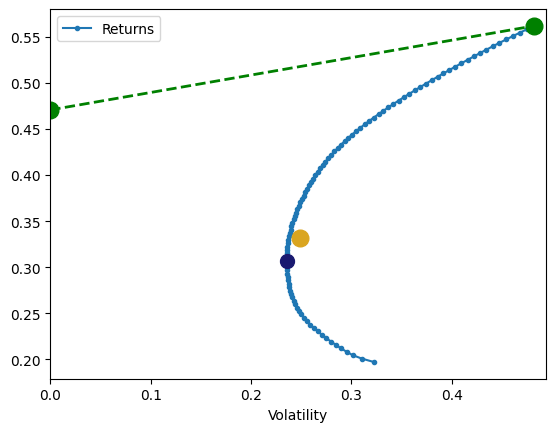

In [132]:
plot_ef(n_points=100, er=er_min_risk, cov=cov_min_risk,
           riskfree_rate=annual_rf, show_ew=True, show_gmv=True, show_cml=True)

In [133]:
weights_gmv_min_risk = gmv(cov_min_risk)
weights_msr_min_risk = msr(riskfree_rate=annual_rf, er=er_min_risk, cov=cov_min_risk)
print("GMV Weights Min Risk:\n", weights_gmv_min_risk, "\n\nMSR Weights Min Risk:\n", weights_msr_min_risk)

GMV Weights Min Risk:
 [0.05784976 0.14203203 0.25176638 0.35494808 0.12379459 0.06960917] 

MSR Weights Min Risk:
 [1.07552856e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38777878e-16 1.00000000e+00]


In [134]:
portfolio_return(weights_gmv_min_risk, er_min_risk) # Expected return of the GMV portfolio
portfolio_vol(weights_gmv_min_risk, cov_min_risk) # Expected volatility of the GMV portfolio
portfolio_return(weights_msr_min_risk, er_min_risk) # Expected return of the MSR portfolio
portfolio_vol(weights_msr_min_risk, cov_min_risk) # Expected volatility of the MSR portfolio
print("GMV Portfolio Return:", portfolio_return(weights_gmv_min_risk, er_min_risk))
print("GMV Portfolio Volatility:", portfolio_vol(weights_gmv_min_risk, cov_min_risk))
print("MSR Portfolio Return:", portfolio_return(weights_msr_min_risk, er_min_risk))
print("MSR Portfolio Volatility:", portfolio_vol(weights_msr_min_risk, cov_min_risk))

GMV Portfolio Return: 0.30641507202428503
GMV Portfolio Volatility: 0.23531835366983636
MSR Portfolio Return: 0.561815865516371
MSR Portfolio Volatility: 0.4817877452660612
